In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import datetime
import json as jsn
import geopandas as gpd
import shapely as shply
import rle as rle
import os as os



In [2]:
infile_hist = xr.open_dataset("//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/irsmf_sfi_P0H000_flow.nc")
infile_histemp = xr.open_dataset(r"\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\test_silo_sfi_drill_max_temp.nc")

parentdire = '//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/'
filelist = os.listdir('//fs1-cbr.nexus.csiro.au/{ev-mdb-outlook}/work/IRSMF_curated_results/')
filelist = [file for file in filelist if '.nc' in file]
filelist = [parentdire + file for file in filelist if '_P0' in file]

infiles = xr.open_mfdataset(filelist, combine = 'nested', concat_dim= 'scenario')

scenarios = [file.split('0')[1] for file in filelist]
scenarios

infiles = infiles.assign_coords({'scenario' :scenarios})

In [3]:
sites_to_use = np.where(np.isfinite(infile_hist['flow']).all(dim = "time"))

In [4]:
infiles

<xarray.Dataset> Size: 286MB
Dimensions:         (scenario: 4, station: 214, time: 41638)
Coordinates:
  * station         (station) int32 856B 1 2 3 4 5 6 ... 209 210 211 212 213 214
  * time            (time) datetime64[ns] 333kB 1895-07-01 ... 2009-06-30
  * scenario        (scenario) <U1 16B 'D' 'H' 'M' 'W'
Data variables:
    station_me      (scenario, station) <U48 164kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    station_no      (scenario, station) <U8 27kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    station_id      (scenario, station) int32 3kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    Site            (scenario, station) <U7 24kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    spatial_coords  (scenario, station) <U94 322kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    lon             (scenario, station) float64 7kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    lat             (scenario, station) float64 7kB dask.array<chunksize=(1, 214), meta=np.ndarray>
    flow            (scenario, station, time) float64 285MB dask.array<chunksize=(1, 72, 13880), meta=np.ndarray>
Attributes:
    title:           A continuous daily time series of data generated from IR...
    institution:     MDBA
    source:          IRSMF Outlook23 model results
    catchment:       Murray-Darling Basin
    history:         This data has been generated by the IRSMF for the Outloo...
    comment:         CSIRO has migrated these datasets to netcdf for the purp...
    MDBA_attrs:      Capture required attributes for MDBA data registry systems
    crs:             4283
    data variables:  Flow

In [5]:
stationid = infile_hist['station_no'][sites_to_use].values[24]
stationid

i = sites_to_use[0][24]
print(i)

ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]

starttime = max(infile_hist['time'].min(), infile_histemp['time'].min()).values
endtime = min(infile_hist['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)


indata = infile_hist['flow'][i].sel(time = slice(starttime, endtime)).squeeze()
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime)).squeeze()

27
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000


In [6]:
sites_to_use[0][24]

27

In [7]:
infile_hist['station_me'][sites_to_use].values[24]

'Barrackdale'

In [8]:
stationid = infile_hist['station_no'][sites_to_use].values[24]
stationid

'422203A'

In [9]:
quants = indata.quantile(q = [ 0.99, 0.05]).values
quants

array([5.39491088e+04, 1.60354278e-02])

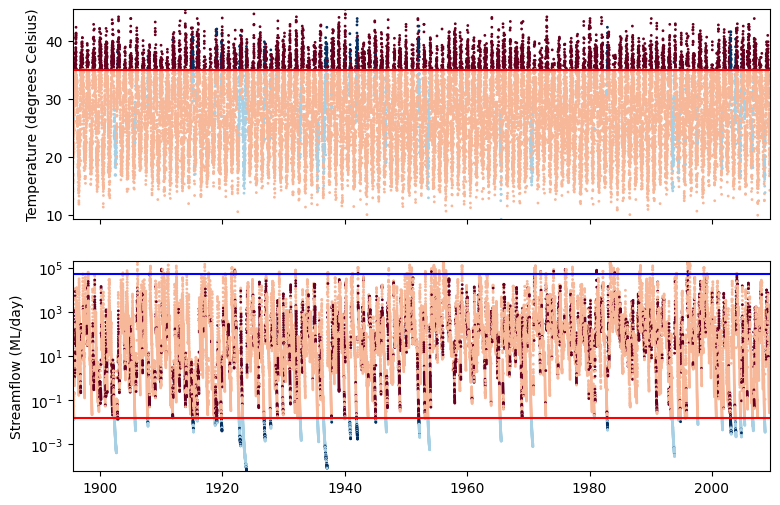

In [10]:
bounds = [-100,35,100]
tempthreshold = 35


colmask = xr.full_like(intemp,1) 
colmask[intemp.values>tempthreshold] = 0
colmask[indata.values<quants[1]] = 2
jointmask = ((intemp>tempthreshold) & (indata<quants[1]) ).compute()
colmask[jointmask.values ] = 3
ncols = len(np.unique(colmask.values))
#cmap = mpl.colors.ListedColormap(["cyan", "darkviolet", "lime", "red"])

cmap = plt.get_cmap('RdBu', (ncols))
bounds = [-1,0.5,1.5,2.5,10]
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=(ncols))

fig, axs = plt.subplots(2,1,figsize=(9,6), sharex=True )
#indata.plot(ax = axs[1])
axs[1].set_yscale('log')
axs[1].plot([indata['time'].min().values, indata['time'].max().values], [quants[0], quants[0]], c = 'b' )
axs[1].plot([indata['time'].min().values, indata['time'].max().values], [quants[1], quants[1]], c='r' )

#axs[0].plot(intemp['time'].values, intemp.values ) 
axs[0].plot([intemp['time'].min().values, intemp['time'].max().values], [tempthreshold, tempthreshold] , c='r')
#axs[0].plot([intemp['time'].min().values, intemp['time'].max().values], [bounds[2], bounds[2]], c='r' )
#axs[0].plot([intemp['time'].min().values, intemp['time'].max().values], [bounds[3], bounds[3]], c='r' )


axs[1].scatter(indata['time'].values, indata.values, c=colmask.values,cmap = cmap, norm = norm, s = 1)
axs[0].scatter(intemp['time'].values, intemp.values, c=colmask.values,cmap = cmap, norm = norm, s = 1)
axs[1].set_ylabel("Streamflow (ML/day)")
axs[0].set_ylabel("Temperature (degrees Celsius)")
axs[0].autoscale(enable = True, tight = True)
axs[1].autoscale(enable = True, tight = True)

fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{stationid}_timeseries.png')
fig.savefig(fig_path,bbox_inches='tight')

In [11]:
aaa = colmask.to_pandas()
aaa = pd.DataFrame(aaa)

In [12]:
aaa.columns = ['values']

In [13]:
aaa

,values
time,
1895-07-01,2.0
1895-07-02,2.0
1895-07-03,2.0
1895-07-04,2.0
1895-07-05,2.0
...,...
2009-06-26,1.0
2009-06-27,1.0
2009-06-28,1.0


In [14]:
aaa['doy'] = aaa.index.dayofyear.values
aaa['year']= aaa.index.year.values

In [15]:
bbb = aaa.pivot_table(values = 'values', index = 'year',columns='doy')

In [16]:
bbb

doy,1,2,3,4,5,6,7,8,9,10,...,357,358,359,360,361,362,363,364,365,366
year,,,,,,,,,,,,,,,,,,,,,
1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
1896,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1897,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
1898,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN
1899,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
2007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


Text(0, 0.5, 'Year')

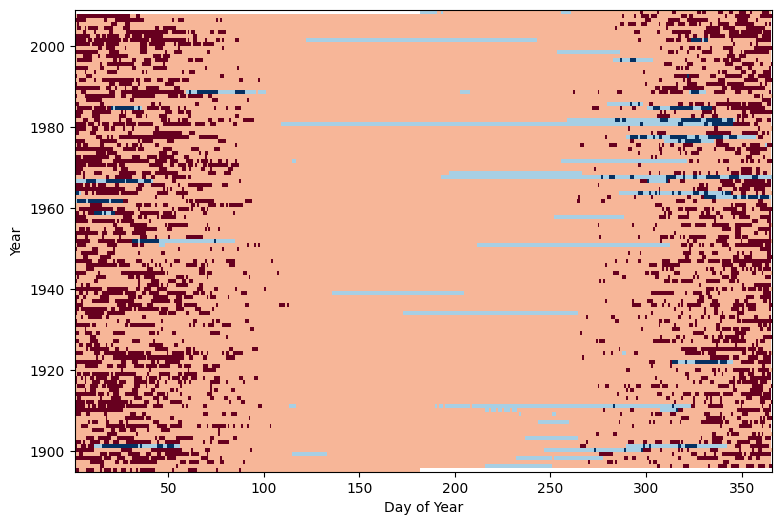

In [17]:
fig, axs = plt.subplots(1,1,figsize=(9,6),  squeeze=False)

axs[0,0].imshow(bbb, cmap = cmap, norm = norm, interpolation='none', extent =[aaa['doy'].min(), aaa['doy'].max(), aaa['year'].min(), aaa['year'].max()], aspect = 'auto' )
axs[0,0].set_xlabel("Day of Year")
axs[0,0].set_ylabel("Year")

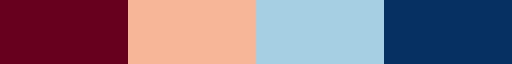

In [18]:
cmap

In [19]:
table_data = pd.DataFrame({"Flow": indata.values < quants[1],"Temp":intemp.values >35, "Date":indata['time'].values})
table_data.set_index('Date',inplace=True)


In [20]:
pd.crosstab(table_data['Temp'],table_data['Flow'],margins=True)

Flow,False,True,All
Temp,,,
False,33850,1718,35568
True,5706,364,6070
All,39556,2082,41638


In [21]:
grouped = table_data.groupby(['Flow','Temp'])
grouped.size()

Flow   Temp 
False  False    33850
       True      5706
True   False     1718
       True       364
dtype: int64

In [24]:
def encodingfunc(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>a) for a in bins])
    return(futtrues)

def xrencoding(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc, obj, input_core_dims = [[dim]], output_core_dims=[['counts']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_], kwargs={'bins':bins})

def encodingfunc1(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>=a) for a in bins])
    return futtrues, np.array([trues.mean()]), np.array([trues.shape[0]])

def xrencoding1(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc1, obj, input_core_dims = [[dim]], output_core_dims=[['counts'], ['means'],['lengths']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_,np.float_, np.int_], kwargs={'bins':bins})


def encodingfunc2(data, bins):
    encoding = rle.encode(data)
    trues = np.array([ encoding[1][a] for a in range(len(encoding[0])) if encoding[0][a]])
    futtrues = np.array([sum(trues>=a) for a in bins])
    truesdays = np.array([sum(trues[np.where(trues>=a)[0]]) for a in bins])
    print(futtrues)
    print(truesdays)
    return futtrues, truesdays, np.array([trues.mean()]), np.array([trues.shape[0]])

def xrencoding2(obj, dim, bins):
    return xr.apply_ufunc(encodingfunc2, obj, input_core_dims = [[dim]], output_core_dims=[['counts'], ['counts'], ['means'],['lengths']], vectorize=True, dask = 'parallelized', output_dtypes=[np.int_ , np.int_,np.float_, np.int_], kwargs={'bins':bins})



27
1895-07-01T00:00:00.000000000 2009-06-30T00:00:00.000000000
114
[0.01603543]
[152 113  77  62  54  47  39  35  30  26  24  17  16  15  15  15  15  14
  12  11  10  10   9   9   7   6   6   5   5   5   5   5   5   4   4   4
   3   2   2   2   1   1   1   1   1   1   1   1   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[906 867 795 750 718 683 635 607 567 531 511 434 422 409 409 409 409 392
 356 337 317 317 295 295 247 222 222 195 195 195 195 195 195 162 162 162
 126  89  89  89  49  49  49  49  49  49  49  49  49   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
[95 66 50 37 27 19 15 14 11 10  8  4  2  2  2  2  2  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0

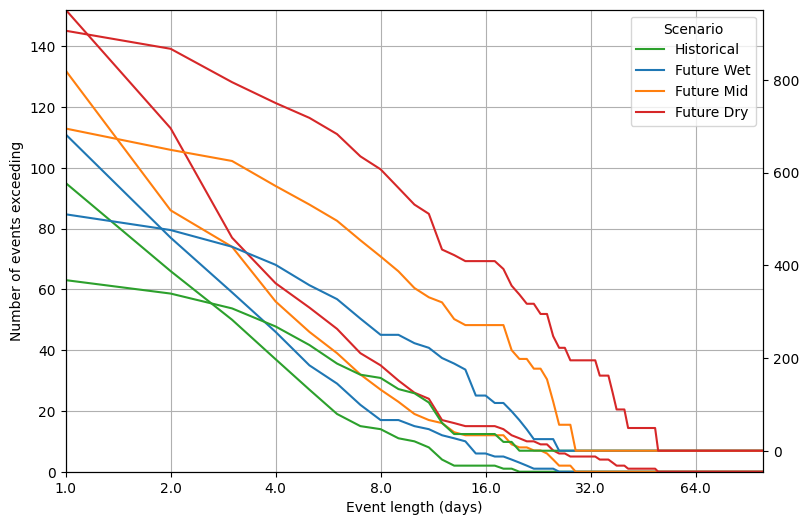

In [27]:

i = sites_to_use[0][24]
print(i)

probs = [0.05]
scenariotemps = np.array([3.65,0.0,2.75,2.0])
tempthresholds = [35]

starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)

nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]

indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
#infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime))
intemp = intemp.squeeze()
indata = indata.chunk(dict(scenario=-1, time = -1))
quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
print(quants)


nx = len(quants)
ny =  len(tempthresholds)
figsize = 5
nbins = 101
bins = np.array([a for a in range(1,nbins,1)])
fig, ax = plt.subplots(ny,nx, figsize=(9,6), squeeze=False)
temp_adjustments = scenariotemps[:,np.newaxis]
#intemp = intemp.drop_vars('station')
testingtemps = intemp.expand_dims(dim={'scenario':4})
testingtemps = testingtemps.assign_coords(coords={'scenario' : indata['scenario'].values})
testingtemps = testingtemps + temp_adjustments

res_list = []
ordered_scenarios = ['H',"W","M","D"]

colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}
scenario_names = {'H':'Historical', 'W':'Future Wet', 'D':'Future Dry', 'M':'Future Mid'}

for thresholdi in range(len(quants)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata<=quants[thresholdi]
        test2data = testingtemps>=tempthresholds[thresholdj]
       # test2data = test2data.assign_coords(coords={'scenario' : indata['scenario']})

        combined = (testdata & test2data).compute()
        #combined = combined.compute()
        result, totaldays, means, counts = xrencoding2(combined,'time', bins=bins)
        result = result.assign_coords({'counts':bins})
        totaldays = totaldays.assign_coords({'counts':bins})
        for scenario in ordered_scenarios:
            ax[thresholdj, thresholdi].plot(result['counts'].values, result.loc[{'scenario':scenario}].values, color = colors[scenario], label = scenario_names[scenario])

#plt.xscale('log')
        #ax[thresholdj, thresholdi].plot( result.values.transpose()) #, c = result['scenario'].values.map(colors))
        #result.plot.line(hue = 'scenario', ax =  ax[thresholdj,thresholdi], )

        ax[thresholdj,thresholdi].set_xscale('log', base = 2)
        if(thresholdj==(len(tempthresholds)-1)):
            ax[thresholdj, thresholdi].set_xlabel('Event length (days)')
        else:
            ax[thresholdj, thresholdi].set_xlabel('')
        if(thresholdi==0):    
            ax[thresholdj, thresholdi].set_ylabel('Number of events exceeding')
        else:
            ax[thresholdj, thresholdi].set_ylabel('')
        ax[thresholdj,thresholdi].grid(True)
        ax[thresholdj,thresholdi].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax[thresholdj,thresholdi].autoscale(enable = True, tight = True)
        #ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )
        ax[thresholdj,thresholdi].legend(loc = "upper right", title = "Scenario")
        ax2 = ax[thresholdj,thresholdi].twinx()  
        #ax2.set_ylim(0, 20)

        for scenario in ordered_scenarios:
            ax2.plot(totaldays['counts'].values, totaldays.loc[{'scenario':scenario}].values, color = colors[scenario], label = scenario_names[scenario])

#plt

        pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0], 'event_frequency': counts.values[:,0]/nyears, '5day_event_frequency': result.sel({'counts':5}).values/nyears})
        pdout['temp_treshold'] =  tempthresholds[thresholdj]
        pdout['flow_percentile'] =  probs[thresholdi]
        pdout['flow_treshold'] =  quants[thresholdi]
        # print(pdout)
        res_list.append(pdout)        
outsummary = pd.concat(res_list)
#print(sum(trues), sum(truesfut))
fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{stationid}_low_flow_event_durations.png')
fig.savefig(fig_path,bbox_inches='tight')



In [ ]:
outsummary

In [ ]:

i = sites_to_use[0][24]
print(i)

probs = [0.99]
scenariotemps = np.array([3.65,0.0,2.75,2.0])
tempthresholds = [-100]

starttime = max(infiles['time'].min(), infile_histemp['time'].min()).values
endtime = min(infiles['time'].max(), infile_histemp['time'].max()).values
print(starttime, endtime)

nyears = round((endtime-starttime)/pd.Timedelta('365.25 days'))
print(nyears)

ii = np.where(infile_histemp['station_no'] == infile_hist['station_no'][i].values)[0]

indata = infiles['flow'].isel({'station':i}).sel(time = slice(starttime, endtime))
#infut = infile_fut['flow'][i].sel(time = slice(starttime, endtime))
intemp = infile_histemp['max_temp'][ii].sel(time = slice(starttime, endtime))
intemp = intemp.squeeze()
indata = indata.chunk(dict(scenario=-1, time = -1))
quants = indata.quantile(q =probs, dim=['time']).sel({'scenario':"H"}).values
print(quants)


nx = len(quants)
ny =  len(tempthresholds)
figsize = 5
nbins = 10001
bins = np.array([a for a in range(1,nbins,1)])
fig, ax = plt.subplots(ny,nx, figsize=(9,6), squeeze=False)
temp_adjustments = scenariotemps[:,np.newaxis]
#intemp = intemp.drop_vars('station')
testingtemps = intemp.expand_dims(dim={'scenario':4})
testingtemps = testingtemps.assign_coords(coords={'scenario' : indata['scenario'].values})
testingtemps = testingtemps + temp_adjustments

res_list = []
ordered_scenarios = ['H',"W","M","D"]

colors = {'H':'tab:green', 'W':'tab:blue', 'D':'tab:red', 'M':'tab:orange'}
scenario_names = {'H':'Historical', 'W':'Future Wet', 'D':'Future Dry', 'M':'Future Mid'}

for thresholdi in range(len(quants)):
    for thresholdj in range(len(tempthresholds)):
        testdata = indata<=quants[thresholdi]
        test2data = testingtemps>=tempthresholds[thresholdj]
       # test2data = test2data.assign_coords(coords={'scenario' : indata['scenario']})

        combined = (testdata & test2data).compute()
        #combined = combined.compute()
        result, means, counts = xrencoding1(combined,'time', bins=bins)
        result = result.assign_coords({'counts':bins})
        ax[thresholdj, thresholdi].plot([(result['counts'].values/365.25).min(), ((result['counts'].values/365.25)).max()], [0,0], color = 'black', linewidth = 0.5)
        for scenario in ordered_scenarios:
            ax[thresholdj, thresholdi].plot(result['counts'].values/365.25, result.loc[{'scenario':scenario}].values, color = colors[scenario], label = scenario_names[scenario])

#plt.xscale('log')
        #ax[thresholdj, thresholdi].plot( result.values.transpose()) #, c = result['scenario'].values.map(colors))
        #result.plot.line(hue = 'scenario', ax =  ax[thresholdj,thresholdi], )
        ax[thresholdj,thresholdi].grid(True)
        ax[thresholdj,thresholdi].set_xscale('log', base = 2)
        if(thresholdj==(len(tempthresholds)-1)):
            ax[thresholdj, thresholdi].set_xlabel('Event length (years)')
        else:
            ax[thresholdj, thresholdi].set_xlabel('')
        if(thresholdi==0):    
            ax[thresholdj, thresholdi].set_ylabel('Number of events exceeding')
        else:
            ax[thresholdj, thresholdi].set_ylabel('')
        ax[thresholdj,thresholdi].set_xlim(1/12.,10000/365)
        ax[thresholdj,thresholdi].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
        ax[thresholdj,thresholdi].autoscale(enable = False, tight = True)
        #ax[thresholdj,thresholdi].set_title( 'flow < ' + str(probs[thresholdi]) + ' percentile and\ntemp > ' + str(tempthresholds[thresholdj]) + 'degrees C' )
        ax[thresholdj,thresholdi].legend(loc = "upper right", title = "Scenario")
        pdout = pd.DataFrame({ 'scenarios':scenarios, 'mean_event_length': means.values[:,0]/365.25,  '1_year_event_count': result.sel({'counts':1*365}).values,  '5_year_event_count': result.sel({'counts':5*365}).values, '10_year_event_count': result.sel({'counts':10*365}).values})
        pdout['temp_treshold'] =  tempthresholds[thresholdj]
        pdout['flow_percentile'] =  probs[thresholdi]
        pdout['flow_treshold'] =  quants[thresholdi]
        # print(pdout)
        res_list.append(pdout)        
outsummary = pd.concat(res_list)

fig_path = os.path.join(r'\\fs1-cbr.nexus.csiro.au\{lw-werp-cafs}\work\rob635\Blackwater\Figures', f'figure_{stationid}_blackwater_interevent_durations.png')
fig.savefig(fig_path,bbox_inches='tight')



In [ ]:
outsummary